In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import root_mean_squared_error

from feature_engine.datetime import DatetimeFeatures

# We will be predicting sales of a retail store using facebook prophet retail sales dataset

In [2]:
df = pd.read_csv('example_retail_sales.csv',parse_dates=['ds'],index_col=['ds'])
df= df.asfreq("MS")
df

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068
...,...
2016-01-01,400928
2016-02-01,413554
2016-03-01,460093


In [3]:
df.tail()

,y
ds,
2016-01-01,400928
2016-02-01,413554
2016-03-01,460093
2016-04-01,450935
2016-05-01,471421


<Axes: xlabel='ds'>

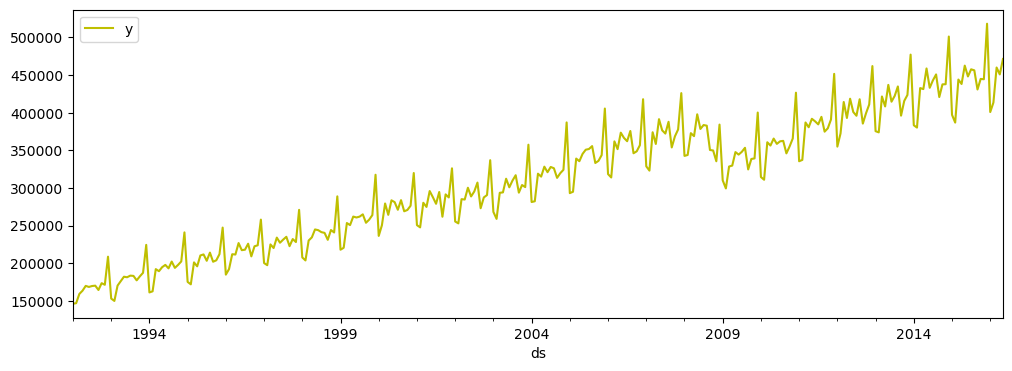

In [4]:
df.plot(figsize=(12,4),color='y')

In [5]:
#understanding trends and seasonality etc.

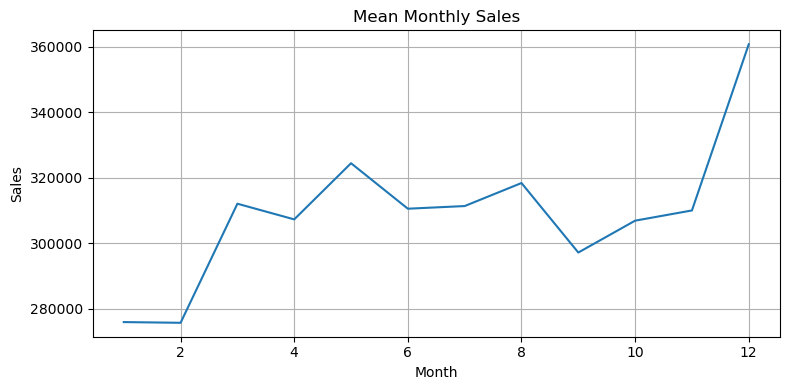

In [6]:
month = df.index.month
df.groupby(month).mean(numeric_only=True)['y'].plot(figsize=(8,4))
plt.title("Mean Monthly Sales")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.tight_layout()
plt.grid(True)
plt.show()

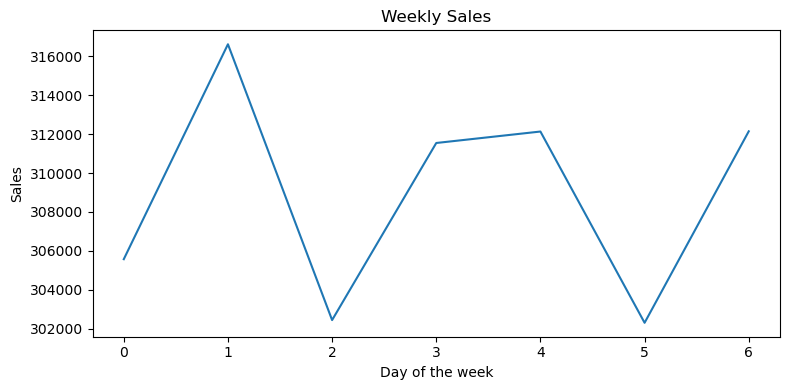

In [7]:
day = df.index.dayofweek

# we take the mean energy consumption per day
df.groupby(day).mean(numeric_only=True)["y"].plot(figsize=(8,4))

# plot
plt.title("Weekly Sales")
plt.ylabel("Sales")
plt.xlabel("Day of the week")
plt.tight_layout()

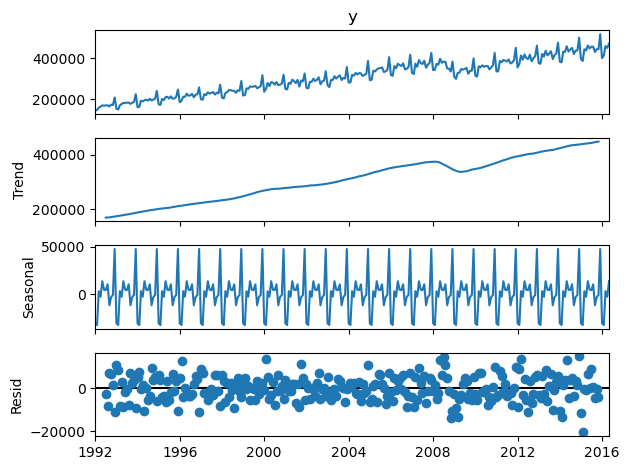

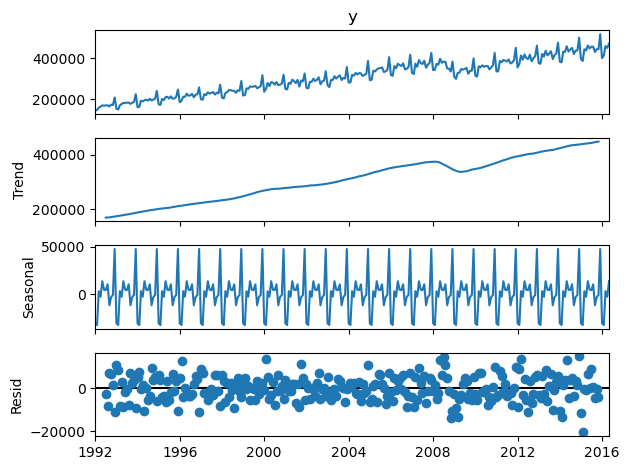

In [8]:
#We can use statsmodels utilities to look at seasonality and trend from the time-series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['y'],model ='additive',period =12)
result.plot()

the time series shows a trend and at least a month's seasonality

In [9]:
#we leave 2004 in the test set
df.index = pd.to_datetime(df.index)

# Define the cutoff date for the split
cutoff_date = '2004-01-01'

# Split the data into training and test sets
X_train = df[df.index < cutoff_date]
X_test = df[df.index >= cutoff_date]

# Checking the size of both sets
print(f'Training set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')
len(X_train)
len(X_test)

Training set size: (144, 1)
Test set size: (149, 1)


149

In [10]:
X_train.tail()

,y
ds,
2003-08-01,317056
2003-09-01,293890
2003-10-01,304036
2003-11-01,301265
2003-12-01,357577


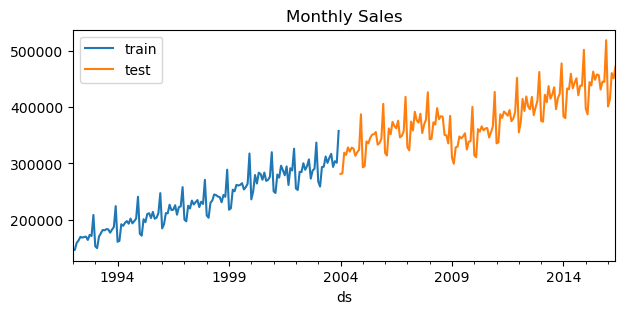

In [11]:
# plot the time series

fig, ax=plt.subplots(figsize=(7, 3))
X_train.plot(ax=ax, label='train')
X_test.plot(ax=ax, label='test')
ax.set_title('Monthly Sales')
ax.legend(["train", "test"])
plt.show()

# Setting up Regression model(lasso regression)

In [12]:
# Lasso regression model
# datetime and sales are not in the
# same scale, so we need to scale the variables

model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lasso", Lasso(random_state=9, alpha=10))
])

We will train a Lasso to forecast sales
We'll use recursive forecasting

In [13]:
# input to the datetime features

# the index needs to match with the series we
# want to forecast

datetime_df = pd.DataFrame(
    X_train.index,
    index=X_train.index,
)

datetime_df

,ds
ds,
1992-01-01,1992-01-01
1992-02-01,1992-02-01
1992-03-01,1992-03-01
1992-04-01,1992-04-01
1992-05-01,1992-05-01
...,...
2003-08-01,2003-08-01
2003-09-01,2003-09-01
2003-10-01,2003-10-01


In [16]:
datetime_f = DatetimeFeatures(
    variables = "ds",
    features_to_extract = ["month", "day_of_week"],
    drop_original=True,
)

In [17]:
forecaster = ForecasterAutoreg(
    regressor=model,              # the machine learning model
    lags=12,                      # the lag features to create
    transformer_exog=datetime_f,  # to get the datetime features
    forecaster_id="recursive"
)

In [18]:
# Fit the model to the data

forecaster.fit(
    y=X_train["y"],     # the series for the lags
    exog=datetime_df,   # the datetime for the datetime features
)

forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lasso', Lasso(alpha=10, random_state=9))]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: DatetimeFeatures(features_to_extract=['month', 'day_of_week'], variables='ds') 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['ds'] 
Training range: [Timestamp('1992-01-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'lasso__alpha': 10, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 9, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-11-0

# forecasting the next three months of sales


In [19]:
# Check the predictor features table created by skforecast.

# These are the input to the Lasso, so it's important to know
# what we are using for training:

X, y = forecaster.create_train_X_y(
    y=X_train["y"],
    exog=datetime_df,
)

X, y

(               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
 ds                                                                       
 1993-01-01  208838.0  171547.0  173655.0  164617.0  170364.0  169890.0   
 1993-02-01  153221.0  208838.0  171547.0  173655.0  164617.0  170364.0   
 1993-03-01  150087.0  153221.0  208838.0  171547.0  173655.0  164617.0   
 1993-04-01  170439.0  150087.0  153221.0  208838.0  171547.0  173655.0   
 1993-05-01  176456.0  170439.0  150087.0  153221.0  208838.0  171547.0   
 ...              ...       ...       ...       ...       ...       ...   
 2003-08-01  309923.0  300998.0  312389.0  294251.0  293693.0  259051.0   
 2003-09-01  317056.0  309923.0  300998.0  312389.0  294251.0  293693.0   
 2003-10-01  293890.0  317056.0  309923.0  300998.0  312389.0  294251.0   
 2003-11-01  304036.0  293890.0  317056.0  309923.0  300998.0  312389.0   
 2003-12-01  301265.0  304036.0  293890.0  317056.0  309923.0  300998.0   
 
                lag_7  

In [20]:
# we need to create the table with datetime from
# which the datetime features will be created:

# this date needs to coincide with the forecasting
# horizon

datetime_df_test = pd.DataFrame(
    X_test.head(3).index,
    index=X_test.head(3).index,
)

datetime_df_test.head()

,ds
ds,
2004-01-01,2004-01-01
2004-02-01,2004-02-01
2004-03-01,2004-03-01


In [21]:
# Predict the next 24 hs

predictions = forecaster.predict(
    steps=3,
    exog=datetime_df_test,
)

predictions.head()

2004-01-01    284034.022826
2004-02-01    268854.147268
2004-03-01    308677.758494
Freq: MS, Name: pred, dtype: float64

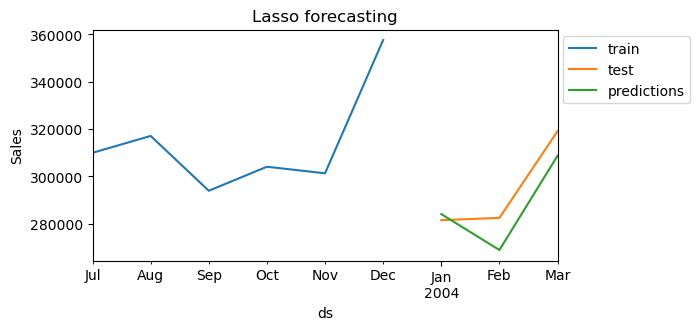

In [22]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(6)["y"].plot(ax=ax, label='train')
X_test.head(3)["y"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel("Sales")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [23]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["y"].head(3),
                y_pred = predictions,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 9990.89443258823


Forecast future data
Forecast 3 months of sales starting on '2004-12-31'.

In [24]:
forecast_start = '2004-12-31'

# we need sales up to 12 months before this point
# because we are using a lag of 12 
past_data_available = X_test[:forecast_start].tail(12)

# data in the past that we know at the point of forecast
past_data_available.shape

(12, 1)

In [25]:
# we also need the datetime in the date 
# range of the forecasting horizon.

# To make predictions `exog` must start 
# one step ahead of `last_window`.

horizon = X_test[forecast_start:].head(3)

datetime_df_test = pd.DataFrame(
    horizon.index,
    index=horizon.index,
)

datetime_df_test

,ds
ds,
2005-01-01,2005-01-01
2005-02-01,2005-02-01
2005-03-01,2005-03-01


In [26]:
predictions = forecaster.predict(
    steps=3,
    last_window=past_data_available["y"],
    exog=datetime_df_test,
)

predictions

2005-01-01    294427.375181
2005-02-01    295468.556623
2005-03-01    330646.433602
Freq: MS, Name: pred, dtype: float64

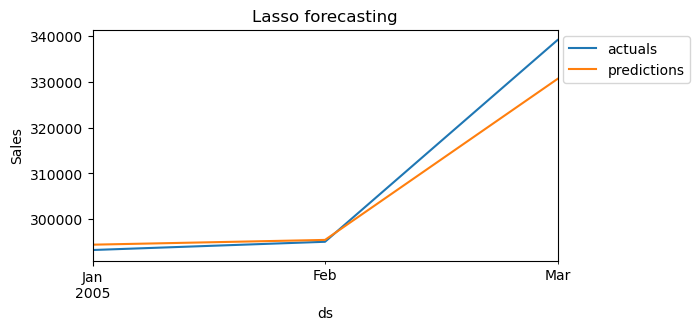

In [27]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
horizon["y"].plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
plt.ylabel('Sales')
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [28]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["y"].head(3),
                y_pred = predictions,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 12538.523147580685
